# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports,-Definitions" data-toc-modified-id="Imports,-Definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports, Definitions</a></div><div class="lev1 toc-item"><a href="#Dijkstra" data-toc-modified-id="Dijkstra-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dijkstra</a></div><div class="lev1 toc-item"><a href="#A*" data-toc-modified-id="A*-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A*</a></div>

[Draw a Map][map]

[map]: https://neighthan.github.io/graphs_and_games/create_map.html

# Imports, Definitions

In [25]:
import numpy as np
import pandas as pd
from heapq import heappush, heappop
from ast import literal_eval
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import namedtuple
import pickle

%matplotlib inline

In [ ]:
grid_cell_types = ['WALL', 'NORMAL', 'START', 'GOAL', 'FRINGE', 'EXPANDED']
grid_colors = ['black', 'white', 'green', 'red', 'lightblue', 'blue']

cmap = ListedColormap(grid_colors)

# don't worry about this part; just for fancy dotted access
GridValues = namedtuple('GridValues', grid_cell_types)
GridValue = namedtuple('GridValue', ['value', 'name', 'color'])
grid = GridValues(*[GridValue(i, grid_cell_types[i], grid_colors[i]) for i in range(len(grid_colors))])

In [3]:


# terrain_colors = np.array([
#     [255, 255, 0, 255], # yellow
#     [244, 164, 96, 255], # sandybrown
#     [144, 238, 144,  255], # lightgreen
#     [0, 100, 0, 255], # darkgreen
#     [128, 128, 128, 255] # grey
# ])


# don't worry about this part; just for fancy dotted access
TerrainValues = namedtuple('GridValues', terrain_types)
TerrainValue = namedtuple('GridValue', ['value', 'name', 'color'])
terrain_values = TerrainValues(*[TerrainValue(i, terrain_types[i], terrain_colors[i])
                                 for i in range(len(terrain_colors))])

In [67]:
terrain_types = ['PATH', 'ROAD', 'GRASSY', 'FOREST', 'ROCKY']
terrain_colors = ['yellow', 'sandybrown', 'lightgreen', 'darkgreen', 'grey']

class Terrain(object):
    def __init__(self, saved_name=''):
        """
        :param terrain_types: must be in order from smallest to largest by their weight
        """
        if saved_name:
            with open(saved_name, 'rb') as f:
                self.grid, self.terrain_types = pickle.load(f)
        else:
            self.grid = np.array(literal_eval(input('Paste map data here')))
            display.clear_output()
            self.terrain_types = literal_eval(input('Paste terrain types here'))
            display.clear_output()

    def __cmap__(self, types):
        return ListedColormap(list(map(lambda terrain_type: terrain_colors[terrain_types.index(terrain_type)], types)))

    def show_terrain(self, grid=None, types=None):
        grid = grid if grid is not None else self.grid
        types = types or self.terrain_types
#         print(types)
        
        unique_vals = np.unique(grid)
        grid = pd.DataFrame(grid).replace({unique_vals[i]: i for i in range(len(unique_vals))}).values

        plt.figure(figsize=(20, 10))
        img = plt.matshow(grid, cmap=self.__cmap__(types), fignum=1, vmin=-0.5, vmax=len(unique_vals)-0.5)
        cbar = plt.colorbar(ticks=np.arange(0, len(unique_vals)))
        cbar.set_ticklabels(types)

    def show_path(self, path):
        grid = self.grid.copy()
        for node in path:
            grid[node] = -1
        self.show_terrain(grid, ['PATH'] + self.terrain_types)

    def __repr__(self):
        self.show_terrain()
        return ''

    def save(self, name):
        with open(name, 'wb') as f:
            pickle.dump((self.grid, self.terrain_types), f)

In [68]:
terrain = Terrain('maps/test1.pkl')

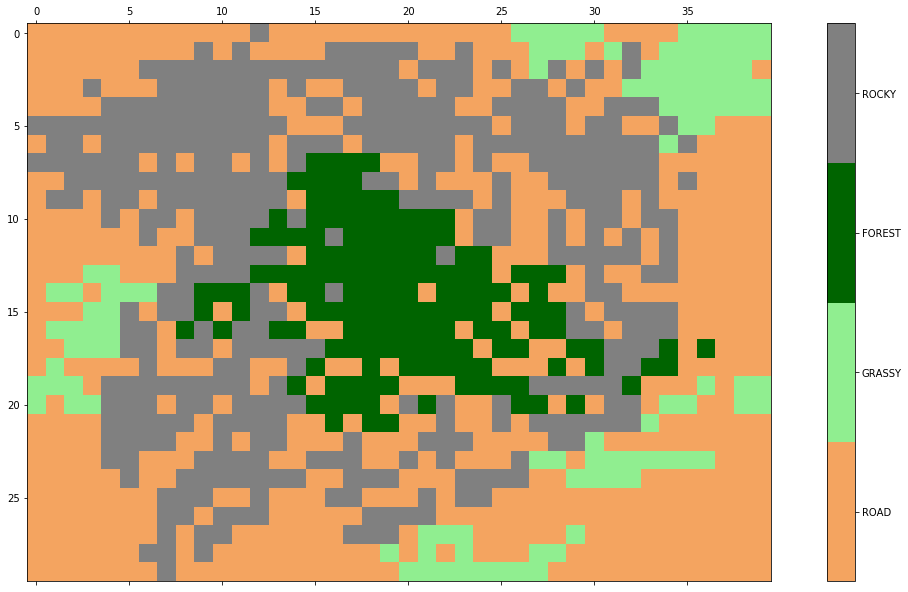

In [65]:
terrain

# Dijkstra

Dijkstra's algorithm only works on graphs with non-negative weights. There are other algorithms that you can use instead of any of the edge's might have a negative weight.



(Here we don't use the decrease-key version of Dijkstra; see a [StackOverflow answer][so] for a comparison of using/not using decrease key for different sorts of priority queues and a [paper][paper] for more in-depth results comparing different versions of Dijkstra for empirical, not only asymptotic, performance)

[so]: https://stackoverflow.com/questions/9255620/why-does-dijkstras-algorithm-use-decrease-key
[paper]: http://www3.cs.stonybrook.edu/~rezaul/papers/TR-07-54.pdf

In [59]:
up = np.array([-1, 0])
down = np.array([1, 0])
left = np.array([0, -1])
right = np.array([0, 1])

def get_neighbors(node_loc, grid, weighted=True):
    upper_bounds = np.array(grid.shape) - 1
    lower_bounds = np.array([0, 0])
    
    neighbors = []
    for direction in [up, down, left, right]:
        neighbor = np.minimum(np.maximum(node_loc + direction, lower_bounds), upper_bounds)
        
        if weighted:
            if not np.all(neighbor == node_loc):
                neighbors.append((tuple(neighbor), grid[tuple(neighbor)]))
        else:
            if not np.all(neighbor == node_loc) and grid[tuple(neighbor)] != grid_values.WALL.value:
                neighbors.append(tuple(neighbor))
    return neighbors

In [60]:
def dijkstra_a_star(grid, start, goal, plot='', video_size=(600, 600), video_path='search.mp4'):
    heap = []
    expanded = set()
    parents = {}
    current_node = start
    path_cost = 0
    parent = None
    
    while True:
        parents[current_node] = parent
        expanded.add(current_node)

        if current_node == goal:
            break

        for (neighbor, weight) in get_neighbors(current_node, grid):
            if neighbor not in expanded:
                heappush(heap, (path_cost + weight, neighbor, current_node))

        while current_node in expanded:
            path_cost, current_node, parent = heappop(heap)

    # make this into a function? we use it here and in bfs_dfs
    path = [goal]
    parent = parents[goal]
    while parent is not None:
        path.append(parent)
        parent = parents[parent]
    path.reverse()
    return path

In [61]:
path = dijkstra_a_star(terrain.grid, (0, 0), tuple(np.array(terrain.grid.shape)-1))

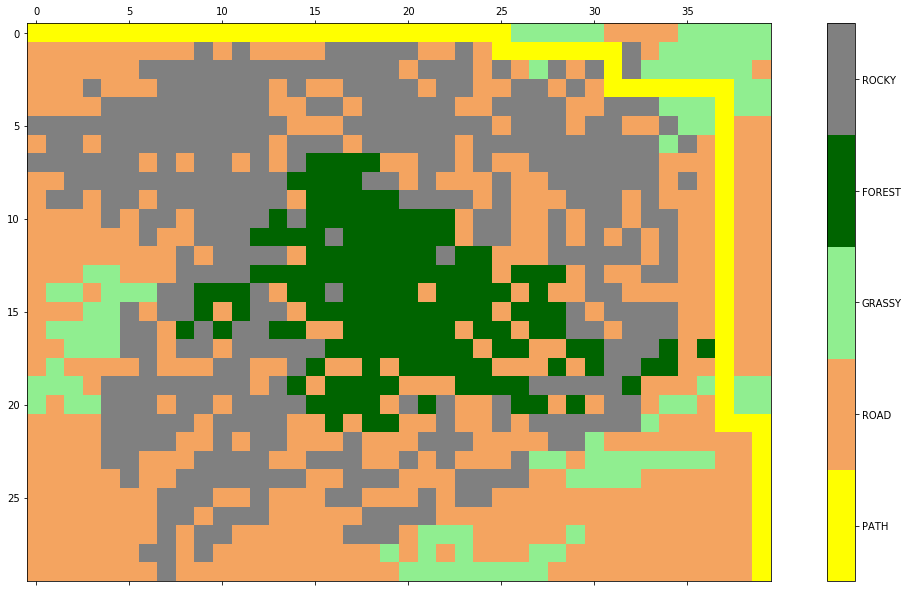

In [69]:
terrain.show_path(path)

# A\*

In [14]:
def a_star(grid, start, goal):
    pass